2000-02-01 12:00:00 	start date
2000-02-07 18:00:00 	end date
A:
      θ0   θ1   θ2   θ3   θ4   θ5   θ6   θ7
q0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
q1  -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
q2   0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0
q3   0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0
q4   0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0
q5   0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0
q6   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
q7   0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
q8   0.0  0.0  0.0  0.0  0.0  0.0 -1.0  1.0
q9   0.0  0.0  0.0  0.0  0.0  1.0  0.0 -1.0
q10  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
q11  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 

G:
q0     2975.000000
q1     1666.000000
q2     1666.000000
q3       80.325000
q4       80.325000
q5       40.000000
q6        8.400000
q7       84.677000
q8      262.500000
q9       40.000000
q10      93.333333
q11    1000.000000
Name: G, dtype: float64 

C:
θ0           0.0
θ1    48200000.0
θ2           0.0
θ3      633556.0
θ4           0.0
θ5      168000.0

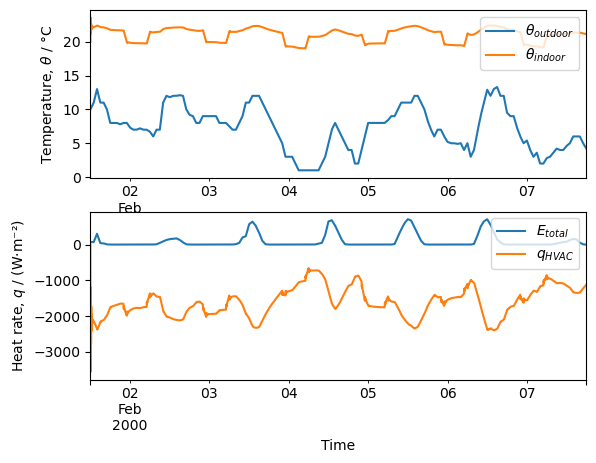

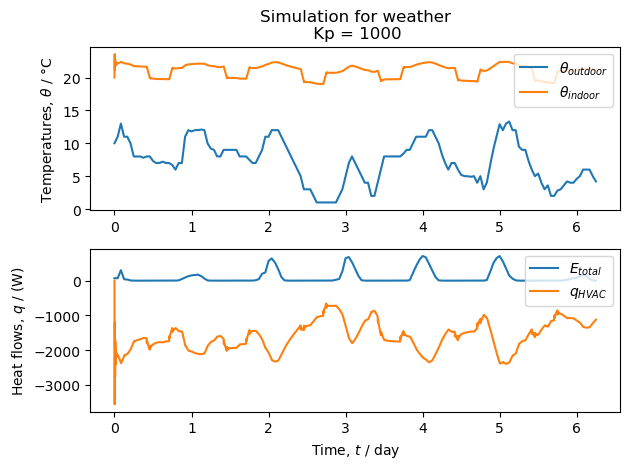

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon May  5 16:02:19 2025

@author: Taupiac Symeon
"""

import numpy as np
import pandas as pd

import dm4bem

# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

# Data
# ====
# dimensions
L, l, H, w = 7, 5, 4, 0.20  # m

# thermo-physical propertites
λ = 1.7             # W/(m K) wall thermal conductivity
# λwood = 0.12 # W/(m K) chestnut thermal conductivity
λglass = 1.05 # W/(m K) glass thermal conductivity
ρ = 1.2 # kg/m3 density
c = 1000   #  J/(kg K) specific heat air
hi, ho = 8, 25      # W/(m2 K) convection coefficients in, out

# outdoor/indoor temperature
To = 40             # °C
Ti = 25             # °C
To_excel = To      # To > Ti d'où le moins

# ventilation rate (air-changes per hour)
ACH = 2             # volume/h


V_dot = L * l * H * ACH / 3600  # volumetric air flow rate
m_dot = ρ * V_dot               # mass air flow rate

legntwindow = l/2  # m length of the window
windowheight = H / 2
Sg = legntwindow* windowheight # m² surface area of the glass 

Sw = 3*(L*H) + 2*(l*H) - Sg # m² surface area of the wall

Swood = L/5 * (3/4)*H



start_date = '02-01 12:00:00'
end_date = '02-07 18:00:00'

start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

# Temperature sources
To = weather['temp_air']

# total solar irradiance
wall_out = pd.read_csv('./pd/bldg/walls_out.csv')
w0 = wall_out[wall_out['ID'] == 'w0']

surface_orientation = {'slope': w0['β'].values[0],
                       'azimuth': w0['γ'].values[0],
                       'latitude': 45}

rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, w0['albedo'].values[0])

Etot = rad_surf.sum(axis=1)

# solar radiation absorbed by the outdoor surface of the wall
Φo = w0['α1'].values[0] * Sw * Etot


# solar radiation absorbed by the indoor surface of the wall
Φi = τ_gSW * w0['α0'].values[0] * Sg * Etot

# solar radiation absorbed by the glass
Φa = α_gSW * Sg * Etot

# indoor air temperature set-point
Ti_sp1 = pd.Series(20, index=To.index)
Ti_sp2 = pd.Series(20, index=To.index)

Ti_day_summer, Ti_night_summer, Ti_day_winter, Ti_night_winter = 25, 22, 20, 18

Ti_sp1 = pd.Series(
    [Ti_day_summer if 6 <= hour <= 22 else Ti_night_summer for hour in To.index.hour],
    index=To.index)

Ti_sp2 = pd.Series(
    [Ti_day_winter if 6 <= hour <= 22 else Ti_night_winter for hour in To.index.hour],
    index=To.index)

# auxiliary (internal) sources
Qa = 3500 * np.ones(weather.shape[0])

# Input data set
input_data_set = pd.DataFrame({'To': To, 'Ti_sp2': Ti_sp2,
                               'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa,
                               'Etot': Etot})
input_data_set.to_csv('./toy_model/input_data_set.csv')








##### perfect controller



import matplotlib.pyplot as plt

controller = True
Kp = 1000    # W/°C, controller gain

neglect_air_capacity = False
neglect_glass_capacity = False

explicit_Euler = True

imposed_time_step = False
Δt = 100    # s, imposed time step 

# MODEL
# =====
# Thermal circuits
TC = dm4bem.file2TC('./toy_model/TC_steady_with_controller.csv', name='', auto_number=False)

# by default TC['G']['q11'] = 0 # Kp -> 0, no controller (free-floating
if controller:
    TC['G']['q11'] = Kp     # G11 = Kp, conductance of edge q11
                            # Kp -> ∞, almost perfect controller
if neglect_air_capacity:
    TC['C']['θ6'] = 0       # C6, capacity of vertex θ6 (air)
if neglect_glass_capacity:
    TC['C']['θ7'] = 0       # C7, capacity of vertex θ7 (glass) 

# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)
dm4bem.print_TC(TC)


λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
dtmax = 2 * min(-1. / λ)    # max time step for Euler explicit stability
dt = dm4bem.round_time(dtmax)

if imposed_time_step:
    dt = Δt

dm4bem.print_rounded_time('dt', dt)


# INPUT DATA SET
# ==============
input_data_set = pd.read_csv('./toy_model/input_data_set.csv',
                             index_col=0,
                             parse_dates=True)
input_data_set

input_data_set = input_data_set.resample(
    str(dt) + 'S').interpolate(method='linear')
input_data_set.head()

# Input vector in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)
u.head()


# Initial conditions
θ0 = 20.0                   # °C, initial temperatures
θ = pd.DataFrame(index=u.index)
θ[As.columns] = θ0          # fill θ with initial valeus θ0

I = np.eye(As.shape[0])     # identity matrix

if explicit_Euler:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = (I + dt * As) @ θ.iloc[k] + dt * Bs @ u.iloc[k]
else:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = np.linalg.inv(
            I - dt * As) @ (θ.iloc[k] + dt * Bs @ u.iloc[k])
        
# outputs
y = (Cs @ θ.T + Ds @  u.T).T


Kp = TC['G']['q11']     # controller gain
S = 35                   # m², surface area of the toy house
q_HVAC = Kp * (u['q11'] - y['θ5'])  # W
y['θ5']

data = pd.DataFrame({'To': input_data_set['To'],
                     'θi': y['θ5'],
                     'Etot': input_data_set['Etot'],
                     'q_HVAC': q_HVAC})


fig, axs = plt.subplots(2, 1)
data[['To', 'θi']].plot(ax=axs[0],
                        xticks=[],
                        ylabel='Temperature, $θ$ / °C')

axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Etot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / (W·m⁻²)')
axs[1].set(xlabel='Time')
axs[1].legend(['$E_{total}$', '$q_{HVAC}$'],
              loc='upper right')
plt.show();


t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot outdoor and indoor temperature
axs[0].plot(t / 3600 / 24, data['To'], label='$θ_{outdoor}$')
axs[0].plot(t / 3600 / 24, y.values, label='$θ_{indoor}$')
axs[0].set(ylabel='Temperatures, $θ$ / °C',
           title=f'Simulation for weather\n Kp = {Kp:.0f}')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, data['Etot'], label='$E_{total}$')
axs[1].plot(t / 3600 / 24, q_HVAC, label='$q_{HVAC}$')
axs[1].set(xlabel='Time, $t$ / day',
           ylabel='Heat flows, $q$ / (W)')
axs[1].legend(loc='upper right')

fig.tight_layout()